## GPT 구현하기

Transformer와 비교해 변경이 필요한 부분
- positional encoding을 따로 추가하는게 아니라 Embedding layer에서 같이 학습될 수 있도록 구성해야함
- Encoder-Decoder 구조가 아닌 Decoder만 활용한 모델 구조로 변경
- masked self Attention만 사용하므로 look ahead mask만 활용
- Unsupervised Learning 이므로 pre-training시 target 데이터는 입력 데이터를 right-shift 시킨 형태로 구성

In [1]:
import tensorflow as tf
import numpy as np

2025-02-17 16:38:26.389599: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 16:38:26.904202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### 모델 구조 만들기

#### positional encoding을 따로 추가하는게 아니라 Embedding layer에서 같이 학습될 수 있도록 구성

In [2]:
class LearnedPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_position, d_model):
        super(LearnedPositionalEmbedding, self).__init__()
        self.pos_embedding = tf.keras.layers.Embedding(max_position, d_model)
    
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        position = tf.range(seq_len, dtype=tf.int32)  # (seq_len,)
        position_embeddings = self.pos_embedding(position)  # (seq_len, d_model)
        position_embeddings = tf.expand_dims(position_embeddings, axis=0)  # (1, seq_len, d_model)
        return inputs + position_embeddings


class GPTEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_position):
        super(GPTEmbedding, self).__init__()
        self.token_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.position_embedding = LearnedPositionalEmbedding(max_position, d_model)
    
    def call(self, inputs):
        token_embeddings = self.token_embedding(inputs)  # (batch, seq_len, d_model)
        return self.position_embedding(token_embeddings)  # 위치 인코딩 적용

# 사용 예시
vocab_size = 10000
d_model = 512
MAX_Length = 1024 #문장 최대 길이

gpt_embedding = GPTEmbedding(vocab_size, d_model, MAX_Length)


In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0 # 나누어 떨어지지 않으면 수행 불가

    self.depth = d_model // self.num_heads # 여기가 Q,K,V가 muti-head로 나뉘었을 때의 차원 수

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model) # 아직 어텐션 계산 전 형태

    self.dense = tf.keras.layers.Dense(units=d_model)# 다음 레이어로 넘어가는 최종 레이어 

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))# -1은 입력 문장의 길이
    return tf.transpose(inputs, perm=[0, 2, 1, 3])# (batch_size, num_heads, seq_len, depth)

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, tf.shape(query)[0])
    key = self.split_heads(key, tf.shape(key)[0])
    value = self.split_heads(value, tf.shape(value)[0])

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))# (batch_size, seq_len, d_model)

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis , : ]
print("슝=3")

슝=3


In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


#### masked self Attention만 사용하므로 look ahead mask만 활용

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행(셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + inputs)

  # 두 번째 서브 레이어 :  Feed Forward  
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 LayerNormalization 수행
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#### Encoder-Decoder 구조가 아닌 Decoder만 활용한 모델 구조로 변경

In [8]:
def GPT(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            MAX_Length,
            name="GPT"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")


  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)

  # 포지셔널 인코딩 + 임베딩 층
  embeddings = GPTEmbedding(vocab_size, d_model, MAX_Length)(inputs)

  # num_layers만큼 쌓아올린 디코더의 층.
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        name="decoder_layer_{}".format(i),
    )([embeddings, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 데이터셋 준비

In [9]:
import pandas as pd

data = pd.read_csv('ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


#### 데이터 전처리

In [10]:
raw = pd.concat([data['Q'], data['A']], axis=0).reset_index(drop=True)
raw = pd.DataFrame(raw, columns=['text'])
raw['text']

0                          12시 땡!
1                     1지망 학교 떨어졌어
2                    3박4일 놀러가고 싶다
3                 3박4일 정도 놀러가고 싶다
4                         PPL 심하네
                   ...           
23641          티가 나니까 눈치가 보이는 거죠!
23642               훔쳐보는 거 티나나봐요.
23643                      설렜겠어요.
23644    잘 헤어질 수 있는 사이 여부인 거 같아요.
23645          도피성 결혼은 하지 않길 바라요.
Name: text, Length: 23646, dtype: object

In [11]:
raw = raw.drop_duplicates().reset_index(drop=True)
len(raw)

19436

In [12]:
import re

def english_to_korean(word):
    """
    영어 단어를 한글 발음으로 변환
    예) SSD -> 에스에스디
    """
    mapping = {
        'a': '에이', 'b': '비', 'c': '씨', 'd': '디', 'e': '이',
        'f': '에프', 'g': '지', 'h': '에이치', 'i': '아이',
        'j': '제이', 'k': '케이', 'l': '엘', 'm': '엠',
        'n': '엔', 'o': '오', 'p': '피', 'q': '큐',
        'r': '알', 's': '에스', 't': '티', 'u': '유', 
        'v': '브이', 'w': '더블유', 'x': '엑스', 'y': '와이', 'z': '제트'
    }
    return "".join(mapping.get(ch.lower(), ch) for ch in word)

def preprocess_korean_sentence(sentence, remove_stopwords=True):
    """
    1. 앞뒤 공백 제거
    2. 영어 단어는 한글 발음으로 변환 (예: SSD -> 에스에스디)
    3. 최종적으로 한글 숫자 이외의 문자들을 제거
    """
    # 1. 앞뒤 공백 제거
    sentence = sentence.strip()
       
    # 2. 영어 변환: [A-Za-z]+ 패턴에 대해 영어 단어를 한글 발음으로 치환
    sentence = re.sub(r'[A-Za-z]+', lambda m: english_to_korean(m.group()), sentence)
    
    # 3. 한글, 숫자, 공백을 제외한 문자 제거
    sentence = re.sub(r'[^가-힣0-9\s]', '', sentence)
    
    
    return sentence

# 예시 사용
example_text = "SSD 제품은 12개의 기능이 있습니다. 가격은 1500원."
print(preprocess_korean_sentence(example_text, remove_stopwords=False))


에스에스디 제품은 12개의 기능이 있습니다 가격은 1500원


In [13]:
preprocess_korean_sentence(raw.iloc[5]['text'])

'에스디카드 망가졌어'

In [14]:
raw['cleaned'] = raw['text'].apply(preprocess_korean_sentence)
print(raw.head())

              text          cleaned
0           12시 땡!            12시 땡
1      1지망 학교 떨어졌어      1지망 학교 떨어졌어
2     3박4일 놀러가고 싶다     3박4일 놀러가고 싶다
3  3박4일 정도 놀러가고 싶다  3박4일 정도 놀러가고 싶다
4          PPL 심하네          피피엘 심하네


In [15]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(raw['cleaned'], target_vocab_size=2**13)
print("슝=3 ")

/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [16]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [17]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [9057]
END_TOKEN의 번호 : [9058]


In [18]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

9059


In [20]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(raw.iloc[21]['cleaned'])))

정수 인코딩 후의 21번째 질문 샘플: [8740, 1932, 3154]


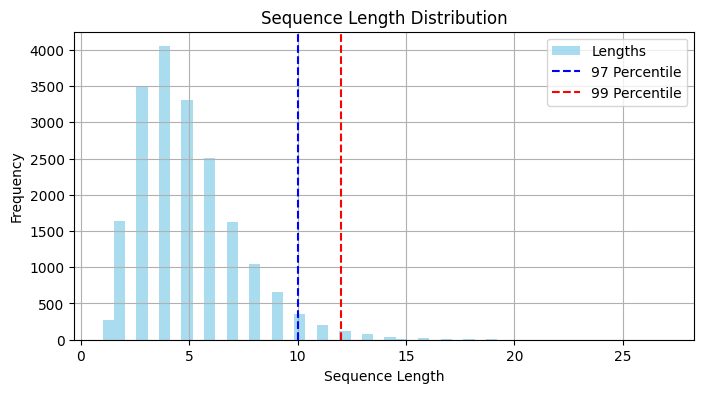

최대 길이: 27
평균 길이: 5.01
97% 백분위수: 10.0
99% 백분위수: 12.0


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 질문과 답변의 토큰 길이 구하기
raw_lengths = [len(tokenizer.encode(q)) for q in raw['cleaned']]

# 길이 분포 시각화
plt.figure(figsize=(8, 4))
plt.hist(raw_lengths, bins=50, alpha=0.7, color='skyblue', label='Lengths')
plt.axvline(x=np.percentile(raw_lengths, 97), color='b', linestyle='--', label='97 Percentile')
plt.axvline(x=np.percentile(raw_lengths, 99), color='r', linestyle='--', label='99 Percentile')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.legend()
plt.grid(True)
plt.show()

# 통계 분석
print(f"최대 길이: {np.max(raw_lengths)}")
print(f"평균 길이: {np.mean(raw_lengths):.2f}")
print(f"97% 백분위수: {np.percentile(raw_lengths, 97)}")
print(f"99% 백분위수: {np.percentile(raw_lengths, 99)}")

In [22]:
tokenizer.eos_token = '[END_TOKEN]'
tokenizer.eos_token_id = END_TOKEN[0]

tokenizer.sos_token = '[START_TOKEN]'
tokenizer.sos_token_id = START_TOKEN[0]

#### 모델 입력 구성

#### Unsupervised Learning 이므로 pre-training시 target 데이터는 입력 데이터를 right-shift 시킨 형태로 구성

In [23]:
# 샘플 99%를 활용하기 위해 최대 길이를 사용
MAX_LENGTH = 12

def create_auto_regressive_data(dataset, tokenizer=tokenizer, max_len=12):
    inputs = []
    targets = []
    
    for sentence in dataset:
        # 문장을 토큰화하고 패딩을 추가
        tokens = tokenizer.encode(sentence)  # 문장을 토큰화
        tokens = tokens[:max_len-1]  # 문장의 길이를 max_len-1로 자르기 (최대 길이 초과 방지)
        
        # 입력과 타겟 시퀀스 생성
        input_seq = [tokenizer.sos_token_id] + tokens
        target_seq = [tokenizer.sos_token_id] + tokens[1:] + [tokenizer.eos_token_id]  # target은 한 칸 오른쪽으로 shift
        
        # 패딩
        input_seq = input_seq + [0] * (max_len - len(input_seq)) #padding은 0
        target_seq = target_seq + [0] * (max_len - len(target_seq))
        
        inputs.append(input_seq)
        targets.append(target_seq)
    
    return inputs, targets
print("슝=3")

슝=3


In [49]:
inputs, targets = create_auto_regressive_data(raw['cleaned'])
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(inputs)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(targets)))
print('입력 데이터 : {}'.format(inputs[:3]))
print('출출력 데이터 : {}'.format(targets[:3]))

단어장의 크기 : 9059
필터링 후의 질문 샘플 개수: 19436
필터링 후의 답변 샘플 개수: 19436
입력 데이터 : [[9057, 5982, 1576, 4174, 0, 0, 0, 0, 0, 0, 0, 0], [9057, 8850, 33, 1047, 8833, 841, 1462, 0, 0, 0, 0, 0], [9057, 8852, 1313, 3516, 8833, 2796, 51, 0, 0, 0, 0, 0]]
출출력 데이터 : [[9057, 1576, 4174, 9058, 0, 0, 0, 0, 0, 0, 0, 0], [9057, 33, 1047, 8833, 841, 1462, 9058, 0, 0, 0, 0, 0], [9057, 1313, 3516, 8833, 2796, 51, 9058, 0, 0, 0, 0, 0]]


In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000
# numpy 배열로 변환 (필수)
inputs = np.array(inputs, dtype=np.int32)
outputs = np.array(targets, dtype=np.int32)

# TensorFlow Dataset 생성
dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))

# 최적화 및 배치 적용
dataset = dataset.cache()  # 데이터셋을 캐시하여 성능 최적화
dataset = dataset.batch(BATCH_SIZE)  # 배치 크기 설정
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # 병렬 처리 최적화

print("슝=3")

# 데이터 확인 (첫 번째 배치 출력)
for batch in dataset.take(1):
    input_batch, output_batch = batch
    print("Sample input batch:", input_batch.numpy()[:5])
    print("Sample output batch:", output_batch.numpy()[:5])

슝=3
Sample input batch: [[9057 5982 1576 4174    0    0    0    0    0    0    0    0]
 [9057 8850   33 1047 8833  841 1462    0    0    0    0    0]
 [9057 8852 1313 3516 8833 2796   51    0    0    0    0    0]
 [9057 8852 1313 3516 8833 1167 2796   51    0    0    0    0]
 [9057  448  448 9037 8952 8953 8833 3927    0    0    0    0]]
Sample output batch: [[9057 1576 4174 9058    0    0    0    0    0    0    0    0]
 [9057   33 1047 8833  841 1462 9058    0    0    0    0    0]
 [9057 1313 3516 8833 2796   51 9058    0    0    0    0    0]
 [9057 1313 3516 8833 1167 2796   51 9058    0    0    0    0]
 [9057  448 9037 8952 8953 8833 3927 9058    0    0    0    0]]


2025-02-17 16:38:33.561900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-17 16:38:33.581458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-17 16:38:33.581541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-17 16:38:33.586797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-17 16:38:33.586856: I tensorflow/compile

#### 모델 인스턴스화

In [26]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기

model = GPT(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    MAX_Length=MAX_LENGTH)

model.summary()

Model: "GPT"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 gpt_embedding (GPTEmbeddin  (None, None, 256)            2322176   ['inputs[0][0]']              
 g)                                                                                               
                                                                                                  
 look_ahead_mask (Lambda)    (None, 1, None, None)        0         ['inputs[0][0]']              
                                                                                                  
 decoder_layer_11 (Function  (None, None, 256)            527104    ['gpt_embedding[0][0]',     

In [27]:
def loss_function(y_true, y_pred):
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)


In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [29]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH))
  print(y_pred[:5])
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


#### 모델 학습

In [30]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
Tensor("strided_slice_1:0", shape=(None, 12, 9059), dtype=float32)
Tensor("strided_slice_1:0", shape=(None, 12, 9059), dtype=float32)


2025-02-17 16:38:37.665571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-17 16:38:37.702923: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7bc01c3200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-17 16:38:37.702966: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-17 16:38:37.707286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-17 16:38:37.717420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-17 16:38:37.773514: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-17 16:38:37.81090

304/304 [==============================] - 24s 73ms/step - loss: 3.9412 - accuracy: 0.1265
Epoch 2/100
304/304 [==============================] - 6s 20ms/step - loss: 2.8790 - accuracy: 0.1671
Epoch 3/100
304/304 [==============================] - 6s 19ms/step - loss: 2.5808 - accuracy: 0.1736
Epoch 4/100
304/304 [==============================] - 6s 18ms/step - loss: 2.3538 - accuracy: 0.1841
Epoch 5/100
304/304 [==============================] - 6s 19ms/step - loss: 2.1151 - accuracy: 0.1974
Epoch 6/100
304/304 [==============================] - 6s 18ms/step - loss: 1.8646 - accuracy: 0.2121
Epoch 7/100
304/304 [==============================] - 5s 18ms/step - loss: 1.6118 - accuracy: 0.2271
Epoch 8/100
304/304 [==============================] - 6s 18ms/step - loss: 1.3687 - accuracy: 0.2421
Epoch 9/100
304/304 [==============================] - 6s 19ms/step - loss: 1.1438 - accuracy: 0.2602
Epoch 10/100
304/304 [==============================] - 6s 19ms/step - loss: 0.9540 - accurac

### inference 결과 확인

In [57]:
def decoder_inference(sentence):
    # 입력 문장 전처리
    sentence = preprocess_korean_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계 (auto-regressive 방식)
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence], training=False)
        predictions = predictions[:, -1:, :]  # 마지막 예측만 사용

        # 현재 예측한 단어의 정수 (예측된 값에서 argmax로 가장 큰 값을 선택)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들을 지속적으로 output_sequence에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

        # 예측한 단어를 입력 시퀀스에 추가
        sentence = tf.concat([sentence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [58]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


### 입력에 따른 출력 생성

In [62]:
sentence_generation('오늘 날씨는')

입력 : 오늘 날씨는
출력 : 않은 좋아하고 인 것 같습니다


'않은 좋아하고 인 것 같습니다'

In [63]:
sentence_generation('배가 너무')

입력 : 배가 너무
출력 : 와


'와'

In [64]:
sentence_generation('오늘')

입력 : 오늘
출력 : 은 시작도 돼


'은 시작도 돼'